In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.preprocessing import image
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install keras_applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:00<00:00, 192MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
tr_df = train_df('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training')
tr_df.head()

,Class Path,Class
0,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
1,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
2,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
3,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
4,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary


In [ ]:
ts_df = test_df('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing')
ts_df.head()

,Class Path,Class
0,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
1,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
2,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
3,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
4,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary


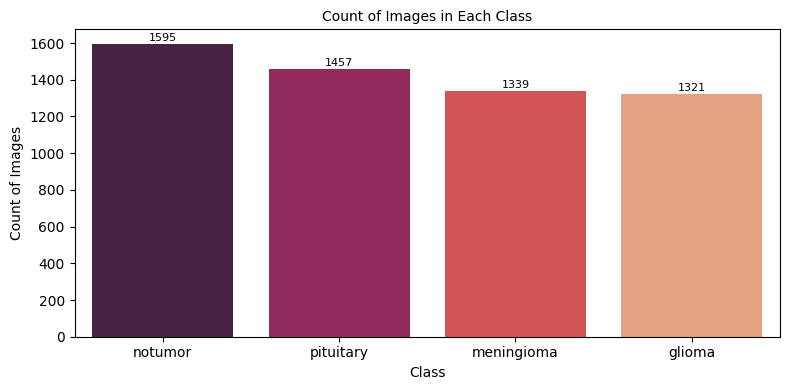

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the count of images in each class
class_counts = tr_df['Class'].value_counts()

# Create a vertical bar plot using Seaborn
plt.figure(figsize=(8,4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='rocket')

# Add labels and title
plt.xlabel('Class', fontsize=10)
plt.ylabel('Count of Images', fontsize=10)
plt.title('Count of Images in Each Class', fontsize=10)

# Add count labels on top of each bar
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=8)

# Show the plot
plt.xticks(rotation=None)
plt.tight_layout()
plt.show()


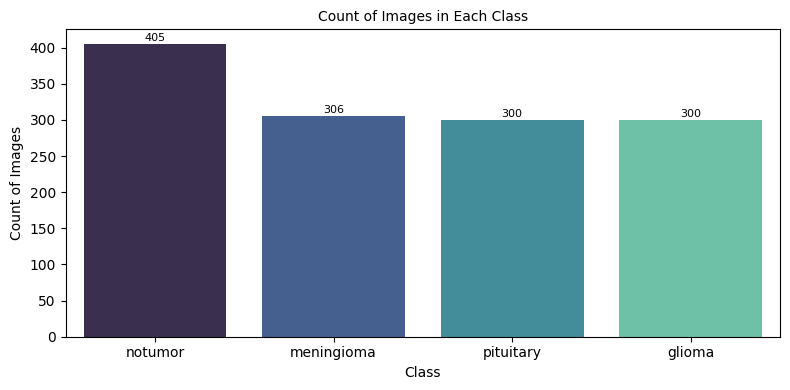

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the count of images in each class
class_counts = ts_df['Class'].value_counts()

# Create a vertical bar plot using Seaborn
plt.figure(figsize=(8,4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='mako')

# Add labels and title
plt.xlabel('Class', fontsize=10)
plt.ylabel('Count of Images', fontsize=10)
plt.title('Count of Images in Each Class', fontsize=10)

# Add count labels on top of each bar
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=8)

# Show the plot
plt.xticks(rotation=None)
plt.tight_layout()
plt.show()


In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
batch_size = 32
img_size = (299, 299)

gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest',  # Fill pixels after transformation
    brightness_range=(0.8, 1.2),  # Random brightness changes
    channel_shift_range=20.0,  # Random channel shift (color variance)
)

ts_gen = ImageDataGenerator(rescale=1/255)


# Training Generator
tr_gen = gen.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,
    class_mode='categorical'  # Assuming multi-class classification
)

# Validation Generator (similar to the test set, without augmentation)
valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,
    class_mode='categorical'
)

# Test Generator (no augmentation, only rescaling)
ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=32,
    target_size=img_size,
    shuffle=False,  # No shuffle in test set
    class_mode='categorical'
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

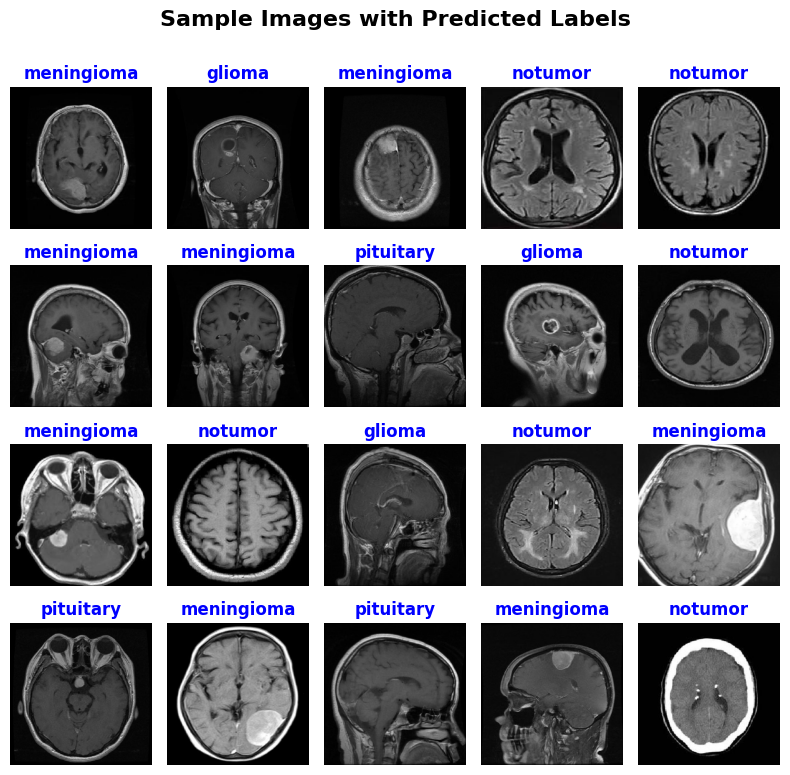

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(ts_gen)
num_images = 20
plt.figure(figsize=(8, 8))

# Loop through the images and labels
for i, (image, label) in enumerate(zip(images[:num_images], labels[:num_images])):
    plt.subplot(4, 5, i + 1)  # Adjust subplot dimensions (4x4 grid for 16 images)
    plt.imshow(image)

    # Get the class name from the label
    class_name = classes[np.argmax(label)]

    # Add title with a larger font size and a color
    plt.title(class_name, color='blue', fontsize=12, fontweight='bold')

    # Remove axis labels for cleaner visualization
    plt.axis('off')

# Improve layout and add a main title for the whole plot
plt.suptitle('Sample Images with Predicted Labels', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust title position to avoid overlap

plt.show()


In [ ]:
def get_source_inputs(tensor):
    """Returns the input tensor of a given tensor if it's part of a model."""
    if K.is_keras_tensor(tensor):
        return tensor
    elif isinstance(tensor, Input):
        return tensor
    else:
        raise ValueError("Input tensor is not valid. It must be a Keras tensor or Input layer.")


In [ ]:
def Xception(require_flatten=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=4):
    if K.backend() != 'tensorflow':
        raise RuntimeError('The Xception model is only available with the TensorFlow backend.')

    input_shape = _obtain_input_shape(input_shape, default_size=299, min_size=71,
                                      data_format=K.image_data_format(), require_flatten= require_flatten)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if require_flatten:
        x = GlobalAveragePooling2D()(x)
        x = Dense(classes, activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='xception')

    return model


In [ ]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [ ]:
model = Xception(require_flatten=True, weights=None)
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 147, 147, 128)  │          8,768 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 147, 147, 128)  │            512 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 147, 147, 128)  │         17,536 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 147, 147, 128)  │            512 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 74, 74, 128)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 74, 74, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)            

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
! pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 49.2 MB/s eta 0:00:00


In [ ]:
! pip install pydot pydot-ng

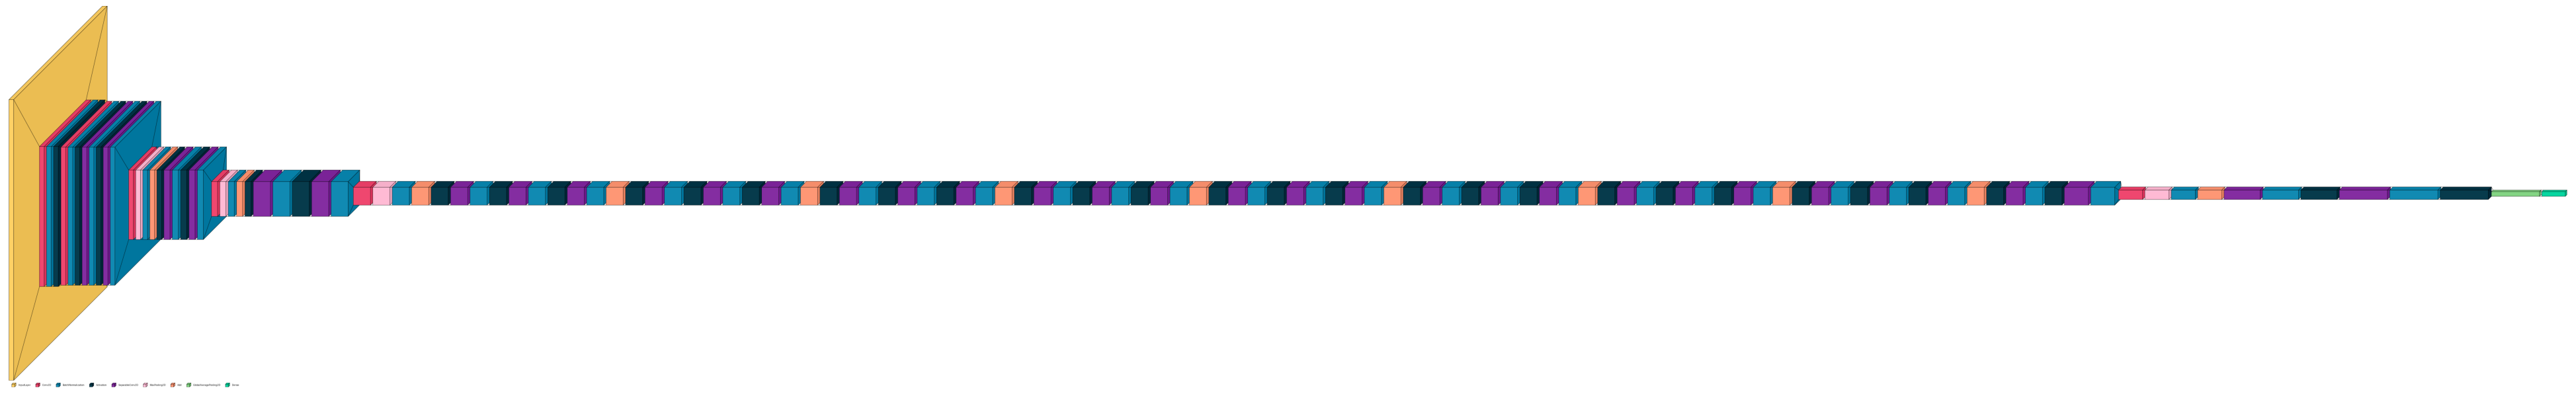

In [ ]:
import matplotlib.pyplot as plt
from visualkeras import layered_view

# Set default font size for the plot
plt.rcParams.update({'font.size': 10})  # Adjust the number as needed

# Create the layered view of your model
image = layered_view(model, legend=True)

# Adjust the figure size for better visualization
plt.figure(figsize=(50, 20))  # You can adjust the size further if needed
plt.imshow(image)

# Display the plot
plt.axis('off')  # Turn off axis for a cleaner view
plt.show()



In [ ]:
 len(model.layers)

134

In [ ]:
# # Unfreeze the last few layers for fine-tuning
# for layer in model.layers[-30:]:  # Adjust number of layers as needed
#   layer.trainable = True

import tensorflow as tf

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [ ]:
from tensorflow.keras.regularizers import l2

final_model  = Sequential([
    model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu', kernel_regularizer=l2(0.001)),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

final_model .compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

final_model .summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 1000)                │      22,910,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,039,124 (87.89 MB)

 Trainable params: 22,984,596 (87.68 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
history = final_model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                callbacks=[lr_scheduler, early_stopping])

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.4199 - loss: 1.4279 - precision: 0.3100 - recall: 0.0041 - val_accuracy: 0.3084 - val_loss: 1.3876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5103 - loss: 1.1552 - precision: 0.8093 - recall: 0.1662 - val_accuracy: 0.2290 - val_loss: 1.5726 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5654 - loss: 1.0234 - precision: 0.8007 - recall: 0.2713 - val_accuracy: 0.2519 - val_loss: 1.5844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6152 - loss: 0.8952 - precision: 0.7974 - recall: 0.3718 - val_accuracy: 0.6595 - val_loss: 0.8842 - val_precision: 0.8567 - val_recall: 0.3924 - learning_rate: 0.0010
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━

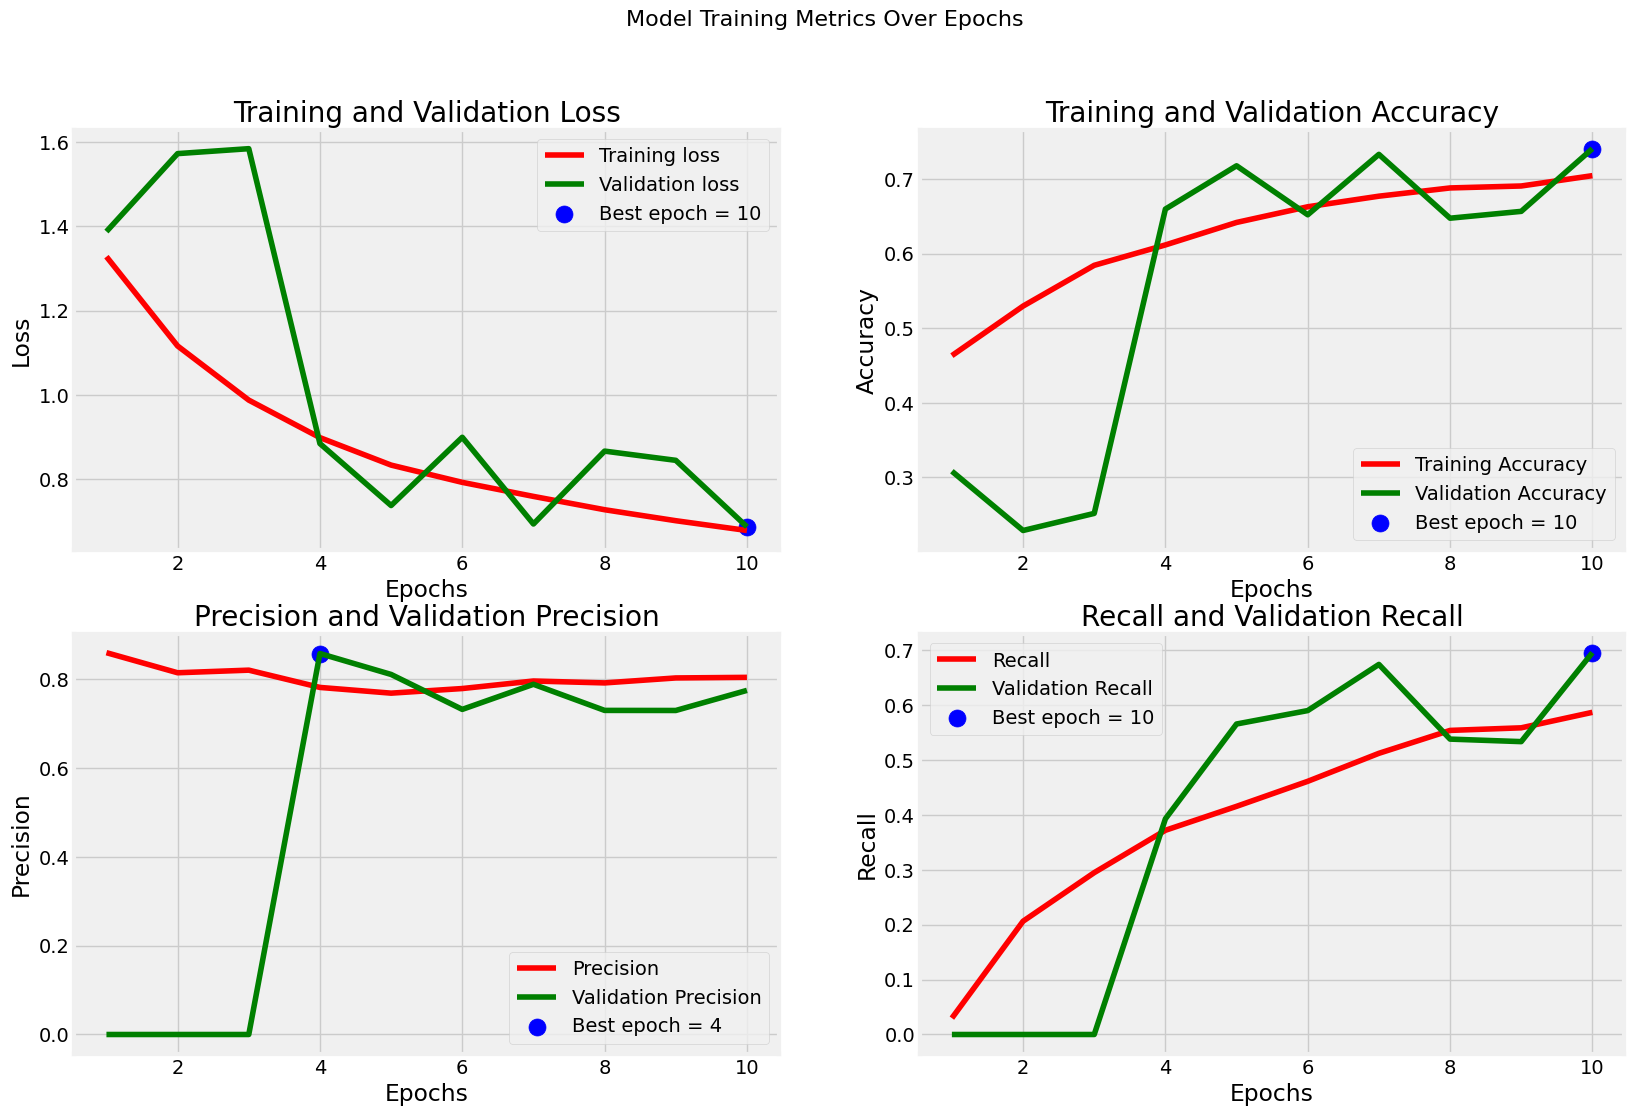

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

NameError: name 'model' is not defined

In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_predict(model, img_path, target_size=(299, 299)):
    """
    Load an image from the given path and predict the class using the provided model.

    Parameters:
    - model: The trained model.
    - img_path: Path to the image file.
    - target_size: The target size to resize the image before prediction (default is (224, 224)).

    Returns:
    - Predicted class label (if using classification) or prediction value.
    """

    # Load the image with the target size for the model input
    img = image.load_img(img_path, target_size=target_size)

    # Convert the image to a numpy array and preprocess it for prediction
    img_array = image.img_to_array(img)

    # Expand dimensions to match the batch size (add the batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image (this step is optional depending on your model's preprocessing)
    img_array = img_array / 255.0  # Typically required for models trained on image data (like in Keras)

    # Predict the class
    predictions = model.predict(img_array)

    # Get the predicted class (for classification tasks)
    # predicted_class = np.argmax(predictions, axis=1)
    label = list(class_dict.keys())
    labels = label

    probs = (predictions[0])
    predicted_class_idx = np.argmax(probs)  # Get index of the class with max probability
    predicted_class = labels[predicted_class_idx]

    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, list(probs))
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

    return predicted_class, predictions


In [ ]:
label = list(class_dict.keys())
label

In [ ]:

# Example usage:
img_path = '/content/tumor.jpg'  # Replace with your image path
predicted_class, predictions = load_and_predict(model, img_path)
print(f"Predicted class: {predicted_class}")
print(f"Prediction details: {predictions}")

In [ ]:
base_model_2 = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')
base_model_2.summary()

In [ ]:
model2 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()